# Team Raj Datathon 2025

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from sklearn.metrics import mean_squared_error
from darts import TimeSeries
from darts.models import (NaiveSeasonal, ExponentialSmoothing, Theta, FFT, LinearRegressionModel, AutoARIMA)
from darts.utils.utils import SeasonalityMode, ModelMode

from sklearn.metrics import root_mean_squared_error, mean_squared_error


C:\Users\hames\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


### Load Data

In [2]:
vis = pd.read_csv("data/visitation_data.csv")
clim = pd.read_csv("data/climate_data.csv")


### Column Detection

In [3]:
def _find_col(cols, target):
    for c in cols:
        if str(c).strip().lower() == target:
            return c
    raise KeyError(f"Missing required column '{target}' (case-insensitive).")

YEAR = _find_col(vis.columns, "year")
WEEK = _find_col(vis.columns, "week")
id_cols = [YEAR, WEEK]
resort_cols = [c for c in vis.columns if c not in id_cols]

# ensure numeric Year/Week
vis[YEAR] = pd.to_numeric(vis[YEAR], errors="coerce").astype("Int64")
vis[WEEK] = pd.to_numeric(vis[WEEK], errors="coerce").astype("Int64")


### Visitation Data Cleaning

In [4]:
vis[resort_cols] = vis[resort_cols].apply(pd.to_numeric, errors="coerce")
vis[resort_cols] = vis[resort_cols].fillna(vis.groupby(WEEK)[resort_cols].transform("median"))
vis[resort_cols] = vis[resort_cols].fillna(vis[resort_cols].median())
vis = vis[~vis[YEAR].isin([2020, 2021])].copy()
vis.to_csv("data/visitation_data_imputed.csv", index=False)


### Aggregations

In [5]:
resort_cols_clean = [c for c in vis.columns if c not in id_cols]

long = vis.melt(id_vars=id_cols, value_vars=resort_cols_clean,
                var_name="Resort", value_name="Visitation")

weekly_resort_avg = (
    long.groupby([WEEK, "Resort"], as_index=False)["Visitation"]
        .mean()
        .sort_values(["Resort", WEEK])
)

vis["Total_Visitation"] = vis[resort_cols_clean].sum(axis=1)
weekly_total_avg = (
    vis.groupby(WEEK, as_index=False)["Total_Visitation"]
       .mean()
       .sort_values(WEEK)
)

yearly_resort_total = (
    long.groupby([YEAR, "Resort"], as_index=False)["Visitation"]
        .sum()
        .sort_values(["Resort", YEAR])
)

yearly_total = (
    vis.groupby(YEAR)[resort_cols_clean].sum().sum(axis=1)
       .reset_index(name="Total_Visitation")
       .sort_values(YEAR)
)

snow = long.dropna(subset=[YEAR, WEEK, "Visitation"]).copy()
years_ok = [y for y in range(2015, 2025) if y not in (2020, 2021)]
snow = snow[snow[YEAR].isin(years_ok) & snow[WEEK].between(1, 15)].copy()
snow = snow.sort_values(["Resort", YEAR, WEEK])
snow["Week_Idx"] = snow.groupby("Resort").cumcount() + 1
snow["Resort"] = pd.Categorical(snow["Resort"], categories=resort_cols_clean, ordered=True)

n_years = snow[YEAR].nunique()
n_weeks = snow[WEEK].nunique()
max_pts = n_years * n_weeks
min_year, max_year = snow[YEAR].min(), snow[YEAR].max() 

snow_avg = (
    snow.groupby("Week_Idx", as_index=False)["Visitation"]
        .mean()
        .rename(columns={"Visitation": "Avg_Visitation"})
)


### Exploratory Data Analysis Plots

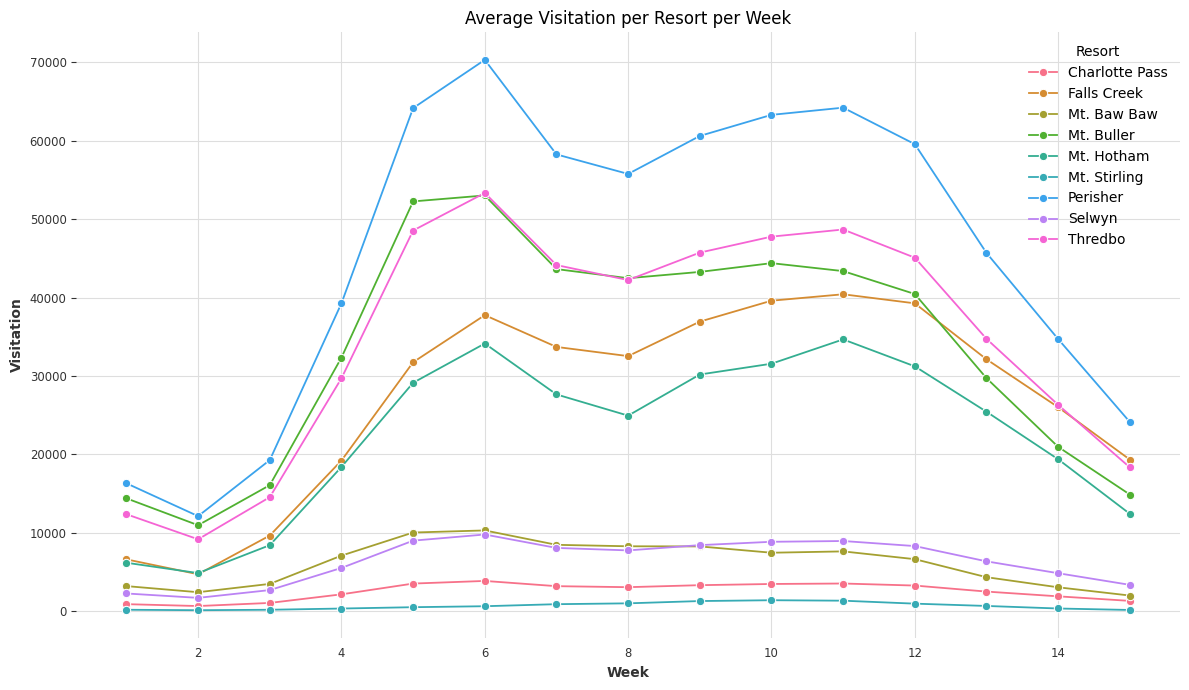

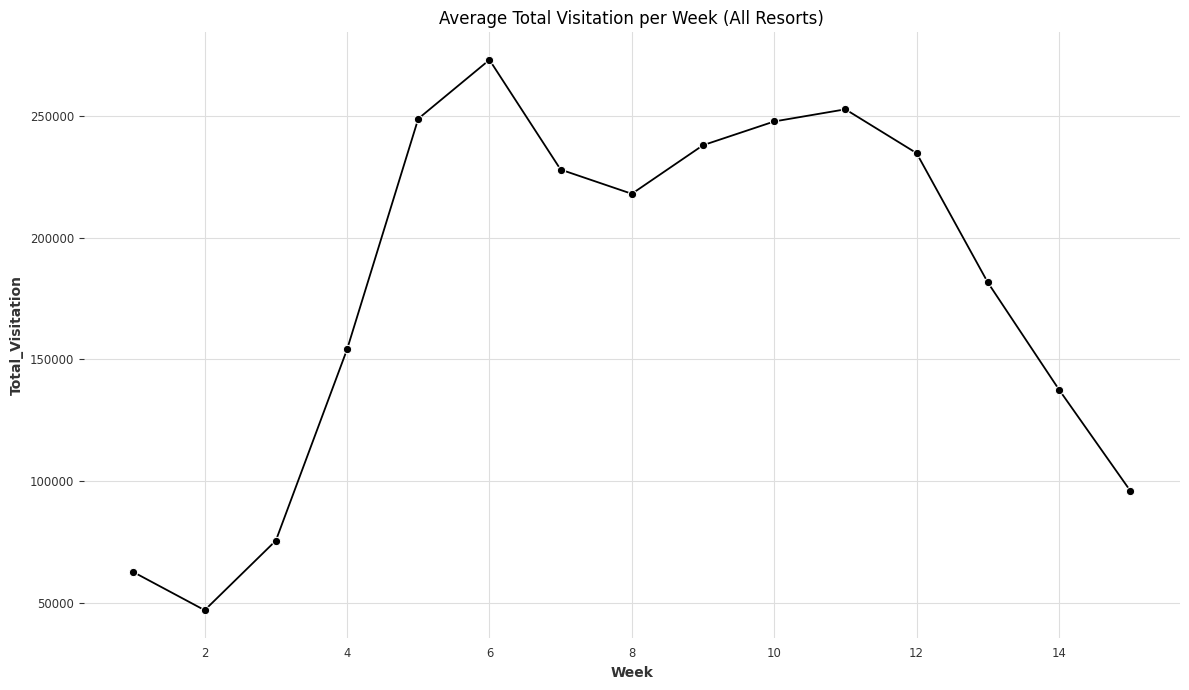

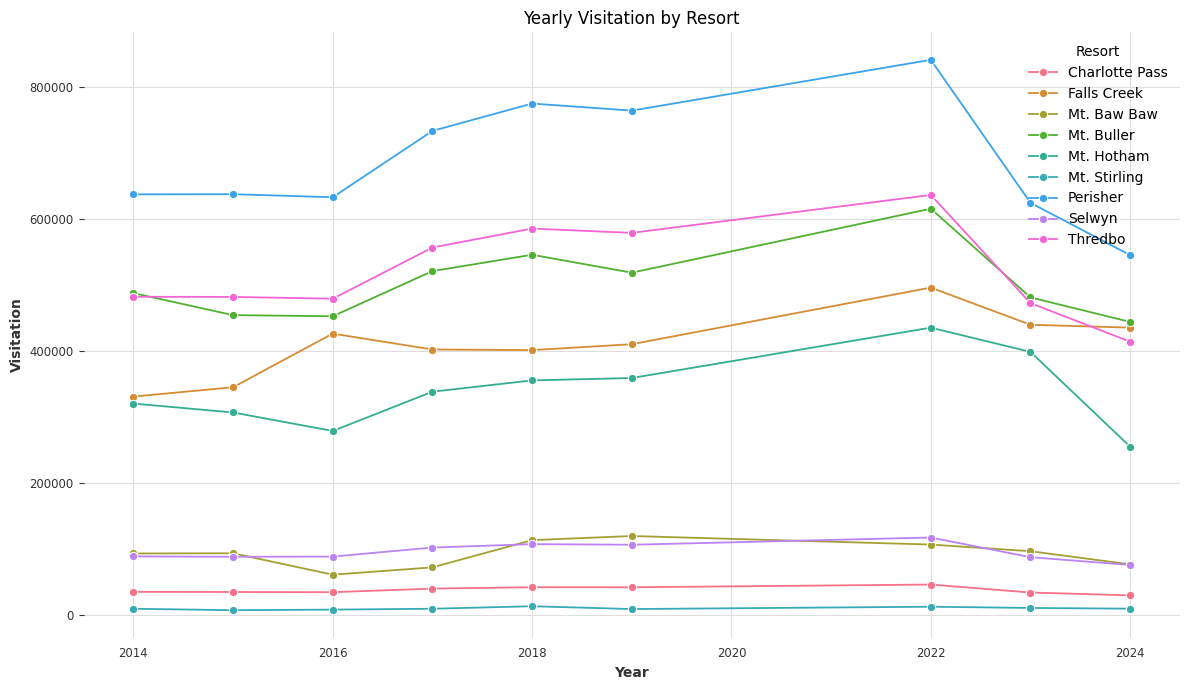

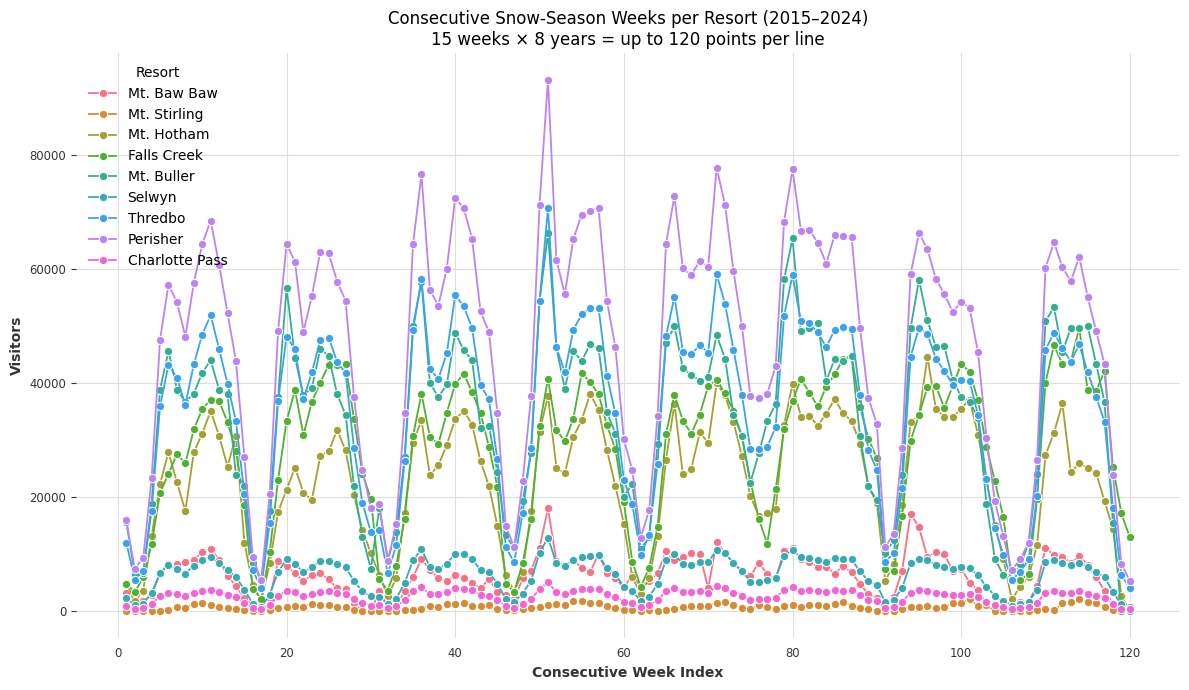

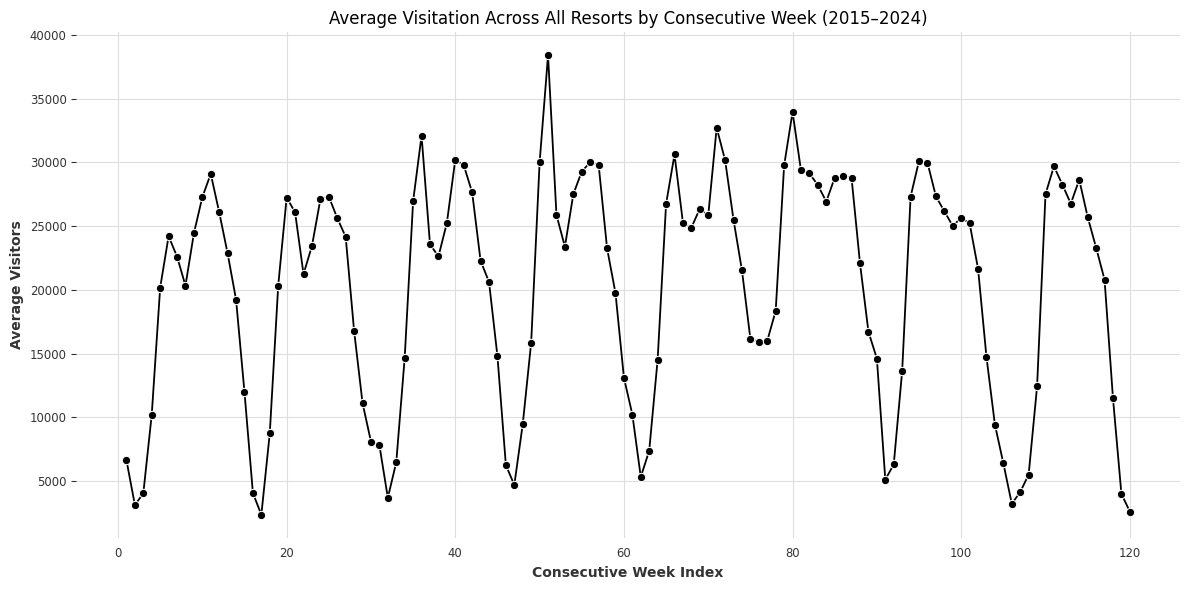

In [6]:
# 1) Average visitation per resort per week
plt.figure(figsize=(12, 7))
sns.lineplot(data=weekly_resort_avg, x=WEEK, y="Visitation", hue="Resort", marker="o")
plt.title("Average Visitation per Resort per Week")
plt.grid(True); plt.tight_layout(); plt.show()

# 2) Average total visitation per week
plt.figure(figsize=(12, 7))
sns.lineplot(data=weekly_total_avg, x=WEEK, y="Total_Visitation", marker="o")
plt.title("Average Total Visitation per Week (All Resorts)")
plt.grid(True); plt.tight_layout(); plt.show()

# 3) Yearly visitation by resort
plt.figure(figsize=(12, 7))
sns.lineplot(data=yearly_resort_total, x=YEAR, y="Visitation", hue="Resort", marker="o")
plt.title("Yearly Visitation by Resort")
plt.grid(True); plt.tight_layout(); plt.show()

# 4) Consecutive snow-season weeks per resort (2015–2019, 2022–2024; weeks 1–15)
plt.figure(figsize=(12, 7))
sns.lineplot(data=snow, x="Week_Idx", y="Visitation", hue="Resort", marker="o")
plt.title(
    f"Consecutive Snow-Season Weeks per Resort ({min_year}–{max_year})\n"
    f"{n_weeks} weeks × {n_years} years = up to {max_pts} points per line"
)
plt.xlabel("Consecutive Week Index")
plt.ylabel("Visitors")
plt.grid(True); plt.tight_layout(); plt.show()


plt.figure(figsize=(12, 6))
sns.lineplot(data=snow_avg, x="Week_Idx", y="Avg_Visitation", marker="o")
plt.title(f"Average Visitation Across All Resorts by Consecutive Week ({min_year}–{max_year})")
plt.xlabel("Consecutive Week Index")
plt.ylabel("Average Visitors")
plt.grid(True); plt.tight_layout(); plt.show()


### Visitor Data Prep

In [7]:
# --- Helper: aggregate to weekly mean across all resorts; keep weeks 1..15
hist = (
    long.dropna(subset=[YEAR, WEEK, "Visitation"])
        .loc[long[WEEK].between(1, 15)]
        .groupby([YEAR, WEEK], as_index=False)["Visitation"].mean()
        .rename(columns={"Visitation": "MeanVisitors"})
        .sort_values([YEAR, WEEK])
)

# Holdout year (use 2025 if present, else the latest)
years = pd.Index(sorted(hist[YEAR].unique()))
eval_year = 2025 if 2025 in years else int(years.max())

train_df = hist[hist[YEAR] < eval_year].sort_values([YEAR, WEEK])
test_df  = hist[hist[YEAR] == eval_year].sort_values(WEEK)

# Make evenly spaced 7-day timeline for Darts
def to_ts(df):
    idx = pd.date_range("2000-06-09", periods=len(df), freq="7D")
    return TimeSeries.from_times_and_values(idx, df["MeanVisitors"].to_numpy())

train_ts = to_ts(train_df)
test_ts  = to_ts(test_df)

scores = {}

### Eval Function

In [ ]:
# --- REPLACE ONLY THIS FUNCTION ---
def eval_model(name, forecast_ts, plot=False):
    """
    Rolling year-ahead backtest across all available years (excl. 2020/2021).
    """
    import numpy as np
    from sklearn.metrics import mean_squared_error

    lname = name.lower()
    builders = {
        "naiveseasonal": lambda: NaiveSeasonal(K=15),
        "exp":           lambda: ExponentialSmoothing(seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=15, trend=ModelMode.NONE),
        "theta":         lambda: Theta(seasonality_period=15, season_mode=SeasonalityMode.ADDITIVE),
        "linear":        lambda: LinearRegressionModel(lags=15),
        "autoarima":     lambda: AutoARIMA(season_length=15),
    }

    # pick a builder by substring match (robust to minor name variations)
    builder = None
    for key in builders:
        if key in lname:
            builder = builders[key]
            break

    years_bt = sorted(y for y in hist[YEAR].unique() if y not in (2020, 2021))
    rmses, last_plot = [], None

    if builder is None:
        # Fallback: if we somehow can't map the name, evaluate the single fold you passed in
        y_true = test_ts.values().ravel()
        y_pred = getattr(forecast_ts, "values", lambda: np.asarray(forecast_ts))().ravel()
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        print(f"{name} (single-year) RMSE: {rmse:.2f}")
        return rmse

    for y in years_bt:
        tr = hist[hist[YEAR] < y].sort_values([YEAR, WEEK])
        te = hist[hist[YEAR] == y].sort_values(WEEK)
        if te.empty or len(tr) < 15:
            continue

        tr_ts, te_ts = to_ts(tr), to_ts(te)
        horizon = len(te_ts)

        try:
            model = builder()
            model.fit(tr_ts)
            fc = model.predict(horizon)

            y_true = te_ts.values().ravel()
            y_pred = fc.values().ravel()
            rmse = mean_squared_error(y_true, y_pred)
            rmses.append((y, rmse))
            last_plot = (y, te, y_true, y_pred)
        except Exception as e:
            print(f"[{name}] fold {y} error: {e}")

    # Print per-year results and average
    for y, r in rmses:
        print(f"{name}  {y}: RMSE {r:.2f}")
    avg = float(np.mean([r for _, r in rmses])) if rmses else float("nan")
    print(f"{name}  AVG RMSE: {avg:.2f} over {len(rmses)} years\n")

    # Optional: plot the last fold for a sanity check
    if plot and last_plot:
        y, te_df, y_true, y_pred = last_plot
        weeks = te_df[WEEK].to_numpy()
        plt.figure(figsize=(8, 4.5))
        plt.plot(weeks, y_true, marker='o', label=f'Actual {y}')
        plt.plot(weeks, y_pred, marker='o', linestyle='--', label=name)
        plt.xlabel('Week'); plt.ylabel('Mean visitors')
        plt.title(f'Backtest - {name}')
        plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    return avg


### Seasonal Naive

In [9]:
# 1) Seasonal Naive (K = 15 weeks)
m_ns = NaiveSeasonal(K=15)
m_ns.fit(train_ts)
fc_ns = m_ns.predict(len(test_ts))
scores["NaiveSeasonal(K=15)"] = eval_model("NaiveSeasonal(K=15)", fc_ns, plot=True)


ImportError: cannot import name 'backtesting' from 'darts.utils.model_selection' (C:\Users\hames\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\darts\utils\model_selection.py)

### Exponential Smooth

C:\Users\hames\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
ValueError: Train series only contains 15 elements but ExponentialSmoothing(trend=ModelMode.NONE, seasonal_periods=15) model requires at least 30 entries


[ExpSmoothing(15, add)] fold 2015 error: Train series only contains 15 elements but ExponentialSmoothing(trend=ModelMode.NONE, seasonal_periods=15) model requires at least 30 entries
ExpSmoothing(15, add)  2016: RMSE 25639245.28
ExpSmoothing(15, add)  2017: RMSE 21349112.97
ExpSmoothing(15, add)  2018: RMSE 9853198.89
ExpSmoothing(15, add)  2019: RMSE 5157341.16
ExpSmoothing(15, add)  2022: RMSE 24266640.43
ExpSmoothing(15, add)  2023: RMSE 34341864.49
ExpSmoothing(15, add)  2024: RMSE 30691417.38
ExpSmoothing(15, add)  AVG RMSE: 21614117.23 over 7 years



C:\Users\hames\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\hames\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\hames\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\hames\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\holtwinters\model.py:918: Convergen

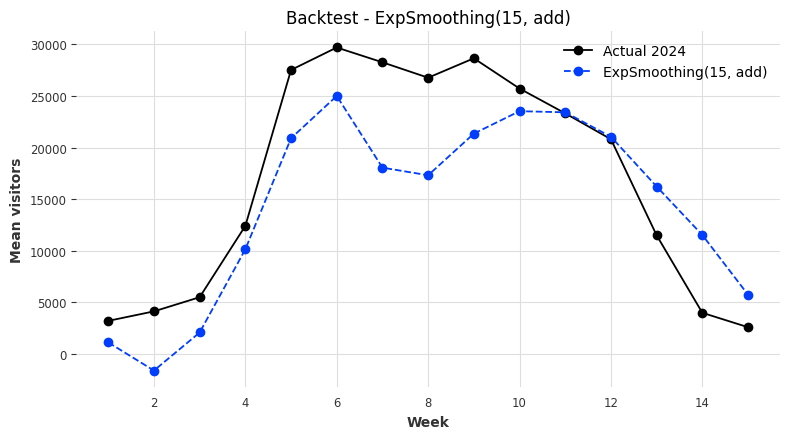

In [ ]:
# 2) Exponential Smoothing (additive seasonality, no trend)
es = ExponentialSmoothing(
    seasonal=SeasonalityMode.ADDITIVE,
    seasonal_periods=15,
    trend=ModelMode.NONE
)
es.fit(train_ts)
fc_es = es.predict(len(test_ts))
scores["ExpSmoothing(15, add)"] = eval_model("ExpSmoothing(15, add)", fc_es, plot=True)

### Theta

C:\Users\hames\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Theta(15, add)  2016: RMSE 20576827.80
Theta(15, add)  2017: RMSE 14494697.14
Theta(15, add)  2018: RMSE 6408420.17
Theta(15, add)  2019: RMSE 5135255.68
Theta(15, add)  2022: RMSE 29964415.99
Theta(15, add)  2023: RMSE 34399624.99
Theta(15, add)  2024: RMSE 25402014.87
Theta(15, add)  AVG RMSE: 19483036.67 over 7 years



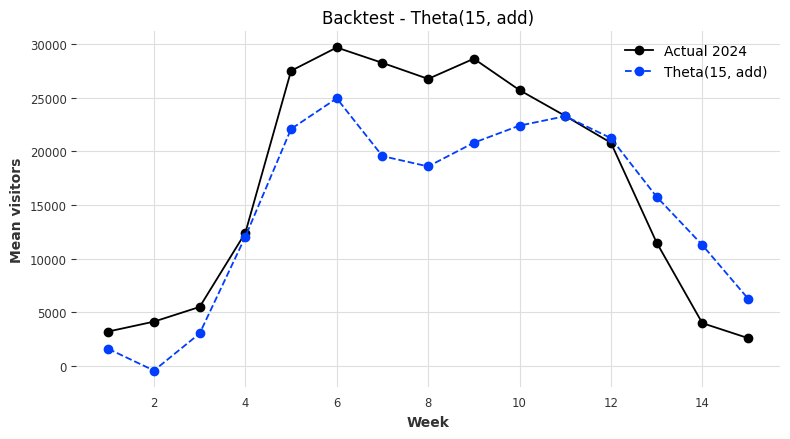

In [ ]:
m_theta = Theta(seasonality_period=15, season_mode=SeasonalityMode.ADDITIVE)
m_theta.fit(train_ts)
fc_theta = m_theta.predict(len(test_ts))
scores["Theta(15, add)"] = eval_model("Theta(15, add)", fc_theta, plot=True)


### Linear Regression on Lags

ValueError: Specified series do not share any common times for which features can be created.


[Linear(lags=15)] fold 2015 error: Specified series do not share any common times for which features can be created.
Linear(lags=15)  2016: RMSE 275727884.26
Linear(lags=15)  2017: RMSE 26377889.34
Linear(lags=15)  2018: RMSE 17748763.82
Linear(lags=15)  2019: RMSE 7046945.08
Linear(lags=15)  2022: RMSE 39329292.45
Linear(lags=15)  2023: RMSE 43963437.23
Linear(lags=15)  2024: RMSE 27581768.73
Linear(lags=15)  AVG RMSE: 62539425.85 over 7 years



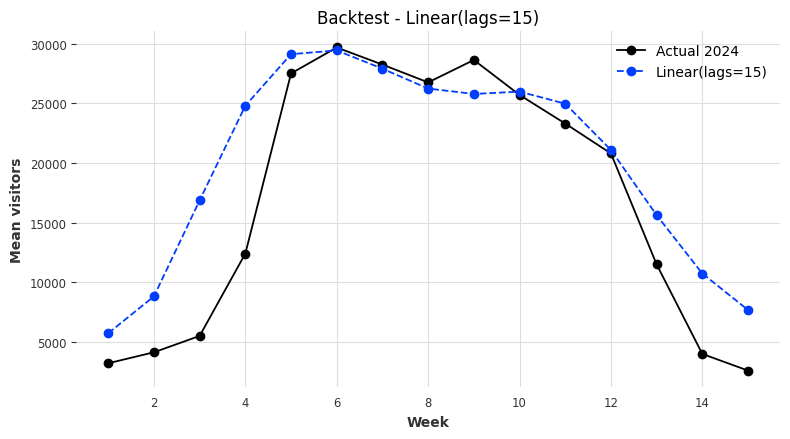

In [ ]:
m_lin = LinearRegressionModel(lags=15)
m_lin.fit(train_ts)
fc_lin = m_lin.predict(len(test_ts))
scores["Linear(lags=15)"] = eval_model("Linear(lags=15)", fc_lin, plot=True)

### Auto Arima

AutoARIMA(m=15)  2015: RMSE 5519438710.97
AutoARIMA(m=15)  2016: RMSE 48549821.19
AutoARIMA(m=15)  2017: RMSE 19952237.61
AutoARIMA(m=15)  2018: RMSE 10954191.53
AutoARIMA(m=15)  2019: RMSE 5740084.68
AutoARIMA(m=15)  2022: RMSE 32121640.44
AutoARIMA(m=15)  2023: RMSE 42607112.93
AutoARIMA(m=15)  2024: RMSE 19720163.43
AutoARIMA(m=15)  AVG RMSE: 712385495.35 over 8 years



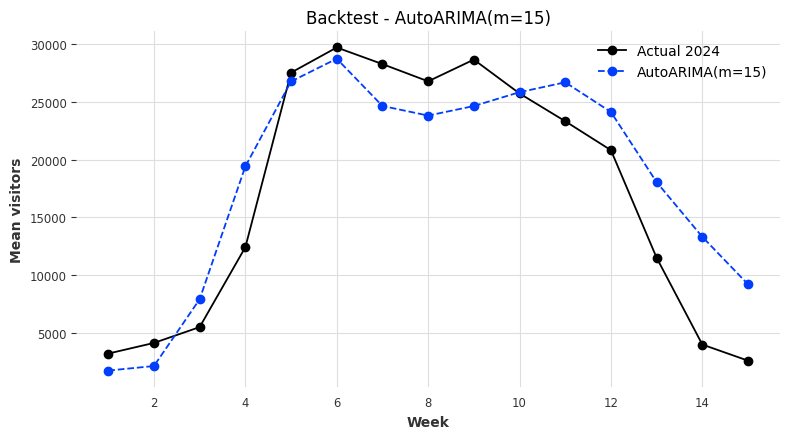

In [ ]:
m_aari = AutoARIMA(season_length=15)
m_aari.fit(train_ts)
fc_aari = m_aari.predict(len(test_ts))
scores["AutoARIMA(m=15)"] = eval_model("AutoARIMA(m=15)", fc_aari, plot=True)

### Score Ranking

In [ ]:
print("\nRMSE leaderboard:")
for name, s in sorted(scores.items(), key=lambda kv: kv[1]):
    print(f"{name:<24} {s:.2f}")


RMSE leaderboard:
Theta(15, add)           19483036.67
NaiveSeasonal(K=15)      21394272.90
ExpSmoothing(15, add)    21614117.23
Linear(lags=15)          62539425.85
AutoARIMA(m=15)          712385495.35


### Ensemble of Top 2

In [ ]:
def backtest_ensemble_avg():
    season = hist[WEEK].nunique()  # e.g., 15 weeks
    years_bt = sorted(y for y in hist[YEAR].unique() if y not in (2020, 2021))
    rmses = []

    for y in years_bt:
        tr = hist[hist[YEAR] < y].sort_values([YEAR, WEEK])
        te = hist[hist[YEAR] == y].sort_values(WEEK)
        if te.empty or len(tr) < season:
            continue

        tr_ts, te_ts = to_ts(tr), to_ts(te)
        horizon = len(te_ts)

        # baseline: Seasonal-Naive always available if len(tr) >= season
        ns_pred = NaiveSeasonal(K=season).fit(tr_ts).predict(horizon).values().ravel()

        # Theta only if we have >= 2*season training points
        th_pred = None
        if len(tr) >= 2 * season:
            th_pred = Theta(seasonality_period=season, season_mode=SeasonalityMode.ADDITIVE) \
                        .fit(tr_ts).predict(horizon).values().ravel()

        # ensemble if both available; otherwise fallback to what's available
        y_hat = 0.5 * (ns_pred + th_pred) if th_pred is not None else ns_pred

        y_true = te_ts.values().ravel()
        rmses.append(mean_squared_error(y_true, y_hat))  # RMSE

    return float(np.mean(rmses)) if rmses else np.nan

print("Ensemble(Theta+NaiveSeasonal) AVG RMSE:", backtest_ensemble_avg())

Ensemble(Theta+NaiveSeasonal) AVG RMSE: 16935874.86076896


C:\Users\hames\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


### Plot Ensemble

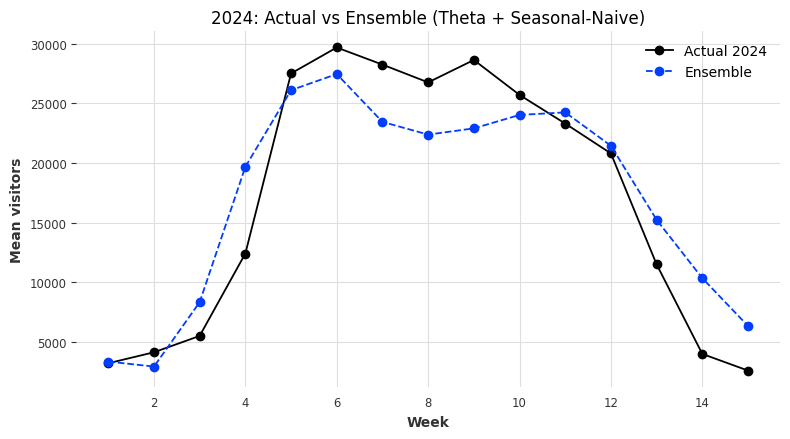

In [ ]:
# --- Plot ensemble (Theta + Seasonal-Naive) vs actual for 2024 ---
season = hist[WEEK].nunique()  # e.g., 15
train_24 = hist[hist[YEAR] < 2024].sort_values([YEAR, WEEK])
test_24  = hist[hist[YEAR] == 2024].sort_values(WEEK)

tr_ts, te_ts = to_ts(train_24), to_ts(test_24)
H = len(te_ts)

# Seasonal-Naive is always available if len(train) >= season
ns = NaiveSeasonal(K=season).fit(tr_ts).predict(H).values().ravel()

# Theta needs >= 2*season training points; fall back to NS if not
if len(train_24) >= 2 * season:
    th = Theta(seasonality_period=season, season_mode=SeasonalityMode.ADDITIVE).fit(tr_ts).predict(H).values().ravel()
    ens = 0.5 * (ns + th)
else:
    ens = ns

weeks  = test_24[WEEK].to_numpy()
actual = te_ts.values().ravel()

plt.figure(figsize=(8, 4.5))
plt.plot(weeks, actual, marker='o', label='Actual 2024')
plt.plot(weeks, ens, marker='o', linestyle='--', label='Ensemble')
plt.xlabel('Week'); plt.ylabel('Mean visitors')
plt.title('2024: Actual vs Ensemble (Theta + Seasonal-Naive)')
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


### 2026 Prediction

    Year  Week  EnsembleForecast
0   2026     1        670.497613
1   2026     2        263.081303
2   2026     3       2555.446474
3   2026     4      10407.511645
4   2026     5      23257.352125
5   2026     6      25741.239930
6   2026     7      22565.514978
7   2026     8      21316.596284
8   2026     9      23374.528925
9   2026    10      22452.799446
10  2026    11      21526.552272
11  2026    12      19270.156126
12  2026    13      11669.532409
13  2026    14       5488.072889
14  2026    15       2478.979624


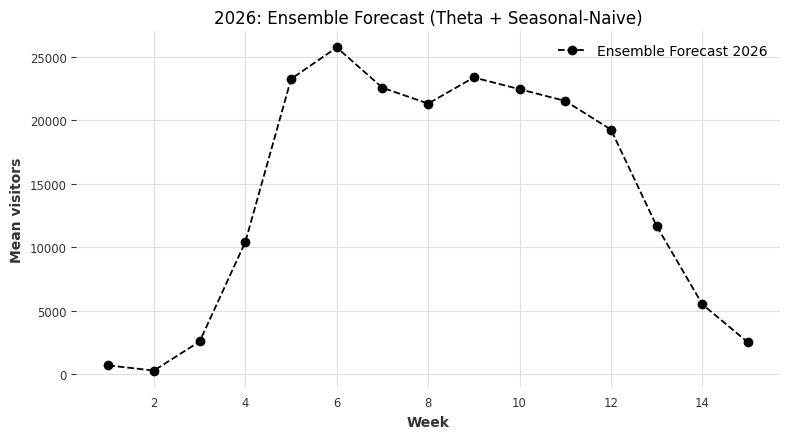

In [ ]:
# --- Ensemble forecast (Theta + Seasonal-Naive) for 2026 ---
import numpy as np

season = hist[WEEK].nunique()  # e.g., 15 weeks
train_26 = hist[hist[YEAR] < 2026].sort_values([YEAR, WEEK])

tr_ts = to_ts(train_26)
H = season  # forecast one full season (weeks 1..season)

# Always have Seasonal-Naive
ns_fc = NaiveSeasonal(K=season).fit(tr_ts).predict(H).values().ravel()

# Theta needs at least 2*season training points; otherwise fall back to NS
if len(train_26) >= 2 * season:
    th_fc = Theta(seasonality_period=season, season_mode=SeasonalityMode.ADDITIVE).fit(tr_ts).predict(H).values().ravel()
    ens_fc = 0.5 * (ns_fc + th_fc)
else:
    ens_fc = ns_fc

weeks_26 = np.arange(1, season + 1)
forecast_2026 = pd.DataFrame({
    "Year": 2026,
    "Week": weeks_26,
    "EnsembleForecast": ens_fc
})
print(forecast_2026)

# Plot the 2026 ensemble forecast
plt.figure(figsize=(8, 4.5))
plt.plot(weeks_26, ens_fc, marker='o', linestyle='--', label='Ensemble Forecast 2026')
plt.xlabel('Week'); plt.ylabel('Mean visitors')
plt.title('2026: Ensemble Forecast (Theta + Seasonal-Naive)')
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()
